In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from fastai.conv_learner import *
from fastai.plots import *

from matplotlib import patches, patheffects

from pathlib import Path

from skimage.io import imread
from skimage.segmentation import mark_boundaries
from skimage.measure import label, regionprops
#from skimage.util.montage import montage2d as montage
#montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

import cv2

cuda.set_device(0)

## Stage 1 Dataset

In [ ]:
PATH = Path('data')
TMP_PATH = "tmp/tmp"
MODEL_PATH = "tmp/model/"
sz = 128
arch = resnet34
bs = 64

In [ ]:
train_masks_fn = f'{PATH}/train_ship_segmentations_v2.csv'
train_masks_path = Path(PATH/'train_ship_segmentations_v2.csv')

train_label_fn = Path(PATH/'train_labels.csv')

images_path = Path(PATH/'train_v2')

masks_path = Path(PATH/'train_masks')

In [ ]:
# Rewrite the train csv file to contain only two columns as expected by fastai'
masks = pd.read_csv(train_masks_fn)
masks.head()

In [ ]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [ ]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [ ]:
first_image = '000155de5.jpg'

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10, 10))
rle_0 = masks.query(f'ImageId=="{first_image}"')['EncodedPixels']
img_0 = masks_as_image(rle_0)
ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')
rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)
ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding',
      'RLE_0:', len(rle_0), '->',
      'RLE_1:', len(rle_1))
show_img(Image.open(images_path/'000155de5.jpg'), ax=ax3)

In [ ]:
#label = masks.copy()

In [ ]:
#label['label'] = masks['EncodedPixels'].apply(lambda x: not pd.isnull(x))

In [ ]:
#label.drop('EncodedPixels', axis=1, inplace=True)

In [ ]:
#label.to_csv(train_label_fn, index=False)

In [14]:
train_label_fn.open().readlines()[:6]

['ImageId,label\n',
 '00003e153.jpg,False\n',
 '0001124c7.jpg,False\n',
 '000155de5.jpg,True\n',
 '000194a2d.jpg,True\n',
 '000194a2d.jpg,True\n']

In [15]:
images_with_ship = masks.ImageId[masks.EncodedPixels.isnull()==False]
images_with_ship = np.unique(images_with_ship.values)
print('There are ' +str(len(images_with_ship)) + ' image files with masks')

There are 42556 image files with masks


In [16]:
'''
# this is for converting the masks to images
%%time
for image_id in masks.ImageId.unique():
    rle_0 = masks.query(f'ImageId=="{image_id}"')['EncodedPixels']
    img_0 = masks_as_image(rle_0)
    
    rle_1 = multi_rle_encode(img_0)
    img_1 = masks_as_image(rle_1)
    #print(len(img_1[img_1>0]))
    cv2.imwrite(f'data/train_masks/mask_{image_id}', img_1[:, :, 0]*255)'''

'\n# this is for converting the masks to images\n%%time\nfor image_id in masks.ImageId.unique():\n    rle_0 = masks.query(f\'ImageId=="{image_id}"\')[\'EncodedPixels\']\n    img_0 = masks_as_image(rle_0)\n    \n    rle_1 = multi_rle_encode(img_0)\n    img_1 = masks_as_image(rle_1)\n    #print(len(img_1[img_1>0]))\n    cv2.imwrite(f\'data/train_masks/mask_{image_id}\', img_1[:, :, 0]*255)'

In [17]:
ims = [open_image(images_path/f'{image_id}') for image_id in masks.ImageId.unique()[:9]]
im_masks = [open_image(masks_path/f'mask_{image_id}') for image_id in masks.ImageId.unique()[:9]]

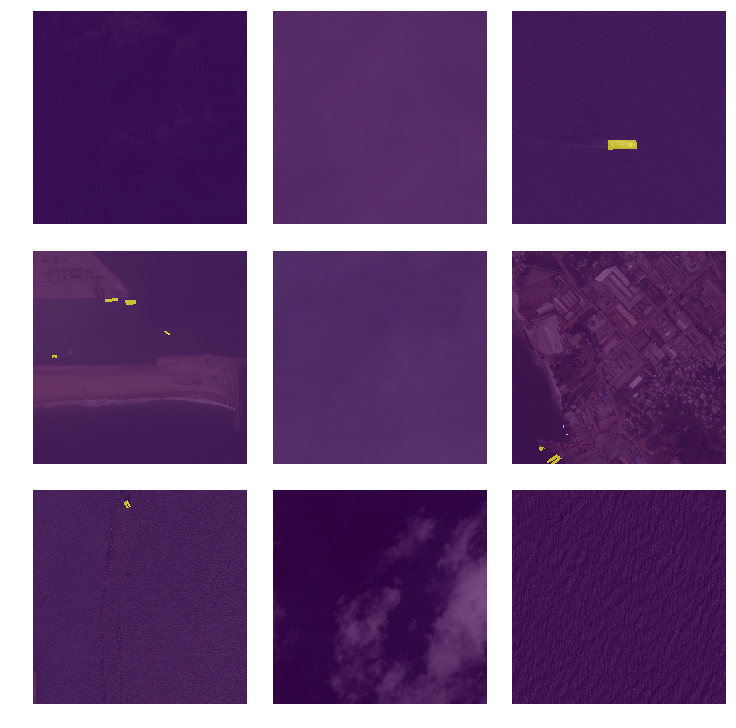

In [18]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
for i,ax in enumerate(axes.flat):
    ax = show_img(ims[i], ax=ax)
    show_img(im_masks[i][...,0], ax=ax, alpha=0.7)
plt.tight_layout(pad=0.1)

In [19]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [20]:
len(masks.ImageId[masks.EncodedPixels.isnull()==True])

150000

In [21]:
x_names = np.array([Path(images_path/f'{image_id}') for image_id in masks.ImageId.unique()])
y_names = np.array([Path(masks_path/f'mask_{image_id}') for image_id in masks.ImageId.unique()])

In [22]:
x_names

array([WindowsPath('data/train_v2/00003e153.jpg'), WindowsPath('data/train_v2/0001124c7.jpg'),
       WindowsPath('data/train_v2/000155de5.jpg'), ..., WindowsPath('data/train_v2/ffff6e525.jpg'),
       WindowsPath('data/train_v2/ffffc50b4.jpg'), WindowsPath('data/train_v2/ffffe97f3.jpg')], dtype=object)

In [23]:
y_names

array([WindowsPath('data/train_masks/mask_00003e153.jpg'),
       WindowsPath('data/train_masks/mask_0001124c7.jpg'),
       WindowsPath('data/train_masks/mask_000155de5.jpg'), ...,
       WindowsPath('data/train_masks/mask_ffff6e525.jpg'),
       WindowsPath('data/train_masks/mask_ffffc50b4.jpg'),
       WindowsPath('data/train_masks/mask_ffffe97f3.jpg')], dtype=object)

In [24]:
val_idxs = get_cv_idxs(len(x_names))
len(x_names), len(val_idxs)

(192556, 38511)

In [25]:
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [26]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.CLASS),
            RandomDihedral(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [27]:
tfms = tfms_from_model(arch, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
data = ImageData(PATH, datasets, bs, num_workers=8, classes=None)

In [28]:
denorm = data.trn_ds.denorm
x,y = next(iter(data.aug_dl))
x = denorm(x)

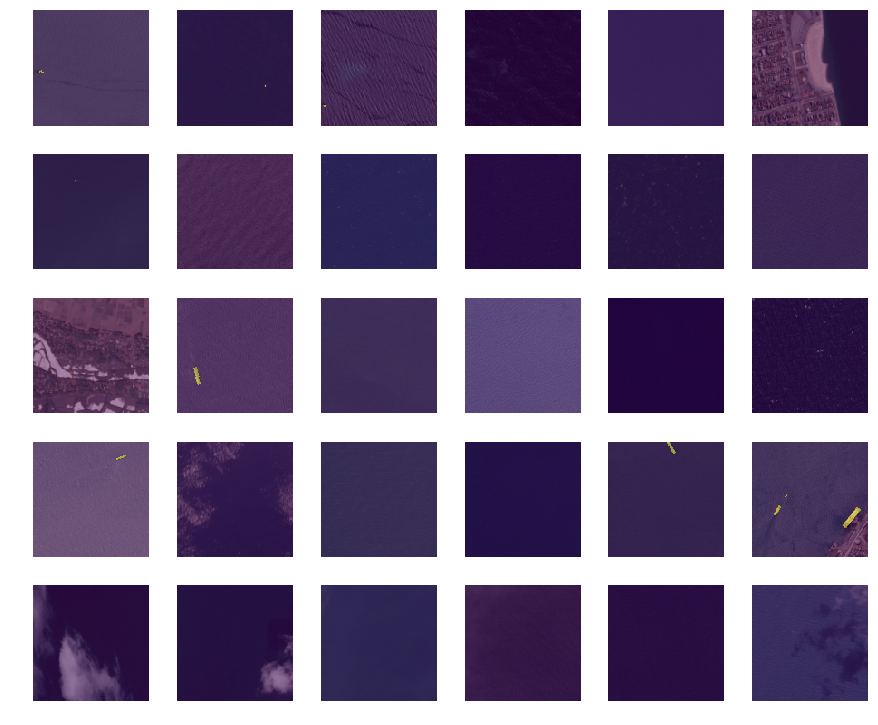

In [29]:
fig, axes = plt.subplots(5, 6, figsize=(12, 10))
for i,ax in enumerate(axes.flat):
    ax=show_img(x[i], ax=ax)
    show_img(y[i], ax=ax, alpha=0.5)
plt.tight_layout(pad=0.1)

In [30]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [31]:
flatten_channel = Lambda(lambda x: x[:,0])

In [32]:
simple_up = nn.Sequential(
    nn.ReLU(),
    StdUpsample(512,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    StdUpsample(256,256),
    nn.ConvTranspose2d(256, 1, 2, stride=2),
    flatten_channel
)

In [33]:
models = ConvnetBuilder(arch, 0, 0, 0, custom_head=simple_up)
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [ ]:
learn.lr_find()
learn.sched.plot()

In [ ]:
lr = 1e-3

In [ ]:
learn.fit(lr, 1, cycle_len=5)#,use_clr=(20,5))

In [ ]:
learn.save('ship_detection_5e')

In [ ]:
learn.load('ship_detection_5e')

In [ ]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=1)#,use_clr=(20,5))

In [ ]:
learn.save('ship_detection_5e3e')

In [34]:
learn.load('ship_detection_5e3e')

In [ ]:
learn.fit(lr, 2, cycle_len=2, cycle_mult=2)#,use_clr=(20,5))

In [ ]:
learn.save('ship_detection_5e3e6em')

In [35]:
py,ay = learn.predict_with_targs()

RuntimeError: cuda runtime error (2) : out of memory at c:\programdata\miniconda3\conda-bld\pytorch_1524549877902\work\aten\src\thc\generic/THCStorage.cu:58

In [ ]:
ay.shape

In [ ]:
show_img(ay[0]);

In [ ]:
show_img(py[0]>0);

In [ ]:
learn.unfreeze()

In [ ]:
learn.bn_freeze(True)

In [ ]:
lrs = np.array([lr/100,lr/10,lr])/4

In [ ]:
learn.fit(lrs,1,cycle_len=20) #,use_clr=(20,10))